# Training Code for Fine-Tuning Google Inceptionv3 Image Classifier Convolutional Neural Network on Horse Data Set for Photography Quality Triage
### (data not available on this site) 

In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,SpatialDropout2D,Dropout
from keras import backend as K
from time import time
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [4]:
# get data and classes
train_datagen = image.ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0.0,
        width_shift_range=0.4,
        height_shift_range=0.2,
        brightness_range=None,
        shear_range=0.2,
        zoom_range=0.2,
        channel_shift_range=0.0,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=1./255,
        preprocessing_function=None,
        data_format=None,
        validation_split=None)

val_datagen = image.ImageDataGenerator(
        fill_mode='nearest',
        rescale=1./255)
    
train_generator = train_datagen.flow_from_directory(
        'data/Training',
        target_size=(299, 299),
        color_mode='rgb',
        classes=None,
        class_mode='categorical',
        batch_size=12,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix='',
        save_format='png',
        follow_links=False,
        subset=None,
        interpolation='lanczos')


    
validation_generator = val_datagen.flow_from_directory(
        'data/Validation',
        target_size=(299, 299),
        color_mode='rgb',
        classes=None,
        class_mode='categorical',
        batch_size=12,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix='',
        save_format='png',
        follow_links=False,
        subset=None,
        interpolation='lanczos')
    

Found 1159 images belonging to 2 classes.
Found 288 images belonging to 2 classes.


In [5]:
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [6]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [7]:
# add a global spatial average pooling layer
x = base_model.output
#x = SpatialDropout2D(0.2, data_format=None)(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 2 output classes
predictions = Dense(2, activation='softmax')(x)

In [8]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()

In [11]:
labels = (train_generator.class_indices)
print(labels)

{'Keepers': 0, 'Rejects': 1}


In [12]:
earlystop = EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=1, mode='min',baseline=None)

In [13]:
# train the model on the new data for a few epochs
history = model.fit_generator(train_generator,
                    steps_per_epoch=None,
                    epochs=500,
                    verbose=1,
                    callbacks=[earlystop],
                    validation_data=validation_generator,
                    validation_steps=None,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)


Epoch 1/500
97/97 [==============================] - 33s 340ms/step - loss: 0.8062 - acc: 0.5379 - val_loss: 0.6906 - val_acc: 0.5104
Epoch 2/500
97/97 [==============================] - 27s 278ms/step - loss: 0.6950 - acc: 0.5495 - val_loss: 0.7328 - val_acc: 0.5000
Epoch 3/500
97/97 [==============================] - 27s 278ms/step - loss: 0.6851 - acc: 0.5735 - val_loss: 0.6848 - val_acc: 0.5312
Epoch 4/500
97/97 [==============================] - 27s 281ms/step - loss: 0.6936 - acc: 0.5468 - val_loss: 0.6903 - val_acc: 0.5069
Epoch 5/500
97/97 [==============================] - 27s 280ms/step - loss: 0.6769 - acc: 0.5580 - val_loss: 0.7015 - val_acc: 0.4896
Epoch 6/500
97/97 [==============================] - 27s 282ms/step - loss: 0.6797 - acc: 0.5732 - val_loss: 0.6889 - val_acc: 0.5417
Epoch 7/500
97/97 [==============================] - 27s 279ms/step - loss: 0.6629 - acc: 0.5967 - val_loss: 0.6771 - val_acc: 0.5729
Epoch 8/500
97/97 [==============================] - 27s 282ms

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


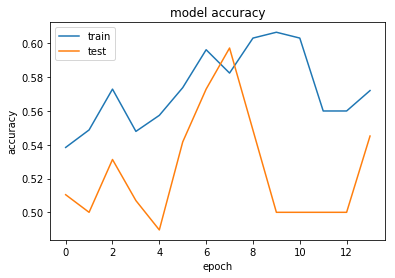

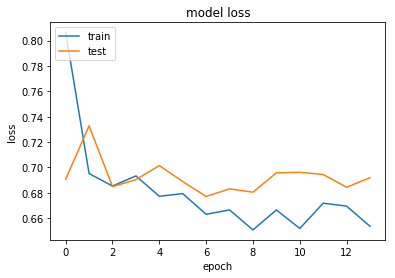

In [14]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

In [16]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [17]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True


In [18]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()

In [19]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(train_generator,
                    steps_per_epoch=None,
                    epochs=1000,
                    verbose=1,
                    callbacks=[tensorboard],
                    validation_data=validation_generator,
                    validation_steps=None,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)

Epoch 1/1000
97/97 [==============================] - 31s 323ms/step - loss: 0.6599 - acc: 0.5916 - val_loss: 0.6895 - val_acc: 0.5729
Epoch 2/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.6529 - acc: 0.6081 - val_loss: 0.6870 - val_acc: 0.6007
Epoch 3/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.6493 - acc: 0.6038 - val_loss: 0.6837 - val_acc: 0.6215
Epoch 4/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.6462 - acc: 0.6105 - val_loss: 0.6804 - val_acc: 0.6215
Epoch 5/1000
97/97 [==============================] - 28s 284ms/step - loss: 0.6418 - acc: 0.6287 - val_loss: 0.6808 - val_acc: 0.6285
Epoch 6/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.6413 - acc: 0.6230 - val_loss: 0.6782 - val_acc: 0.6146
Epoch 7/1000
97/97 [==============================] - 28s 284ms/step - loss: 0.6369 - acc: 0.6270 - val_loss: 0.6772 - val_acc: 0.6285
Epoch 8/1000
97/97 [==============================] - 2

97/97 [==============================] - 27s 282ms/step - loss: 0.4316 - acc: 0.7651 - val_loss: 0.7197 - val_acc: 0.5938
Epoch 122/1000
97/97 [==============================] - 28s 284ms/step - loss: 0.4225 - acc: 0.7673 - val_loss: 0.6866 - val_acc: 0.6076
Epoch 123/1000
97/97 [==============================] - 28s 285ms/step - loss: 0.4033 - acc: 0.7898 - val_loss: 0.6885 - val_acc: 0.6319
Epoch 124/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.4139 - acc: 0.7801 - val_loss: 0.6927 - val_acc: 0.6181
Epoch 125/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.4240 - acc: 0.7611 - val_loss: 0.6905 - val_acc: 0.6250
Epoch 126/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.4146 - acc: 0.7745 - val_loss: 0.6923 - val_acc: 0.6215
Epoch 127/1000
97/97 [==============================] - 28s 285ms/step - loss: 0.4425 - acc: 0.7562 - val_loss: 0.6906 - val_acc: 0.6285
Epoch 128/1000
97/97 [==============================] - 

Epoch 181/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.3101 - acc: 0.8173 - val_loss: 0.8028 - val_acc: 0.6146
Epoch 182/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.3304 - acc: 0.8132 - val_loss: 0.8791 - val_acc: 0.6042
Epoch 183/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.3031 - acc: 0.8181 - val_loss: 0.7702 - val_acc: 0.5972
Epoch 184/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.3374 - acc: 0.8035 - val_loss: 0.8172 - val_acc: 0.6215
Epoch 185/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.3054 - acc: 0.8201 - val_loss: 0.8330 - val_acc: 0.6007
Epoch 186/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.2788 - acc: 0.8439 - val_loss: 0.8056 - val_acc: 0.6111
Epoch 187/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.3060 - acc: 0.8282 - val_loss: 0.7658 - val_acc: 0.6146
Epoch 188/1000
97/97 [===================

Epoch 241/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.2366 - acc: 0.8754 - val_loss: 0.9080 - val_acc: 0.5903
Epoch 242/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.2644 - acc: 0.8673 - val_loss: 0.8670 - val_acc: 0.5972
Epoch 243/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.2641 - acc: 0.8594 - val_loss: 0.8994 - val_acc: 0.5937
Epoch 244/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.2641 - acc: 0.8502 - val_loss: 0.8507 - val_acc: 0.5799
Epoch 245/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.2507 - acc: 0.8622 - val_loss: 0.8522 - val_acc: 0.5903
Epoch 246/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.2639 - acc: 0.8740 - val_loss: 0.9299 - val_acc: 0.5903
Epoch 247/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.2539 - acc: 0.8602 - val_loss: 0.9131 - val_acc: 0.5868
Epoch 248/1000
97/97 [===================

Epoch 301/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.2333 - acc: 0.8697 - val_loss: 0.9303 - val_acc: 0.5903
Epoch 302/1000
97/97 [==============================] - 27s 278ms/step - loss: 0.2416 - acc: 0.8703 - val_loss: 0.9709 - val_acc: 0.5937
Epoch 303/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.2239 - acc: 0.8648 - val_loss: 0.9545 - val_acc: 0.5833
Epoch 304/1000
97/97 [==============================] - 28s 284ms/step - loss: 0.2407 - acc: 0.8694 - val_loss: 0.9747 - val_acc: 0.5729
Epoch 305/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.1855 - acc: 0.8926 - val_loss: 0.9830 - val_acc: 0.5938
Epoch 306/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.2433 - acc: 0.8711 - val_loss: 1.0397 - val_acc: 0.5729
Epoch 307/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.2158 - acc: 0.8920 - val_loss: 0.9809 - val_acc: 0.5799
Epoch 308/1000
97/97 [===================

Epoch 361/1000
97/97 [==============================] - 27s 277ms/step - loss: 0.2168 - acc: 0.8779 - val_loss: 1.0150 - val_acc: 0.5868
Epoch 362/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.2186 - acc: 0.8705 - val_loss: 1.0419 - val_acc: 0.5799
Epoch 363/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.2142 - acc: 0.8868 - val_loss: 1.0269 - val_acc: 0.5694
Epoch 364/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.2065 - acc: 0.8825 - val_loss: 1.0069 - val_acc: 0.5937
Epoch 365/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.2158 - acc: 0.8791 - val_loss: 1.0501 - val_acc: 0.5868
Epoch 366/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.2339 - acc: 0.8762 - val_loss: 1.0404 - val_acc: 0.6250
Epoch 367/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.2210 - acc: 0.8875 - val_loss: 0.9625 - val_acc: 0.6181
Epoch 368/1000
97/97 [===================

Epoch 421/1000
97/97 [==============================] - 28s 284ms/step - loss: 0.2128 - acc: 0.8702 - val_loss: 0.9556 - val_acc: 0.6076
Epoch 422/1000
97/97 [==============================] - 27s 277ms/step - loss: 0.1754 - acc: 0.8917 - val_loss: 0.9884 - val_acc: 0.5903
Epoch 423/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.1842 - acc: 0.8894 - val_loss: 1.0819 - val_acc: 0.5972
Epoch 424/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.1841 - acc: 0.8828 - val_loss: 1.0071 - val_acc: 0.6250
Epoch 425/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.1855 - acc: 0.8862 - val_loss: 1.0397 - val_acc: 0.6181
Epoch 426/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.1840 - acc: 0.8900 - val_loss: 0.9968 - val_acc: 0.6042
Epoch 427/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.1714 - acc: 0.8911 - val_loss: 1.0432 - val_acc: 0.6250
Epoch 428/1000
97/97 [===================

Epoch 481/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.1358 - acc: 0.9618 - val_loss: 1.0936 - val_acc: 0.6076
Epoch 482/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.1277 - acc: 0.9656 - val_loss: 1.0790 - val_acc: 0.6215
Epoch 483/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.1091 - acc: 0.9753 - val_loss: 1.2241 - val_acc: 0.6181
Epoch 484/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.1337 - acc: 0.9613 - val_loss: 1.2348 - val_acc: 0.5903
Epoch 485/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.1595 - acc: 0.9562 - val_loss: 1.1235 - val_acc: 0.5868
Epoch 486/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.1217 - acc: 0.9691 - val_loss: 1.1119 - val_acc: 0.6042
Epoch 487/1000
97/97 [==============================] - 27s 278ms/step - loss: 0.1147 - acc: 0.9699 - val_loss: 1.1201 - val_acc: 0.5937
Epoch 488/1000
97/97 [===================

Epoch 541/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.1010 - acc: 0.9716 - val_loss: 1.1150 - val_acc: 0.6424
Epoch 542/1000
97/97 [==============================] - 27s 278ms/step - loss: 0.1081 - acc: 0.9659 - val_loss: 1.1145 - val_acc: 0.6250
Epoch 543/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.1075 - acc: 0.9734 - val_loss: 1.1557 - val_acc: 0.5903
Epoch 544/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0912 - acc: 0.9768 - val_loss: 1.1808 - val_acc: 0.6250
Epoch 545/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.1051 - acc: 0.9648 - val_loss: 1.1589 - val_acc: 0.6111
Epoch 546/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.1010 - acc: 0.9725 - val_loss: 1.2295 - val_acc: 0.6285
Epoch 547/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.0929 - acc: 0.9794 - val_loss: 1.1743 - val_acc: 0.6181
Epoch 548/1000
97/97 [===================

Epoch 601/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.1020 - acc: 0.9716 - val_loss: 1.2499 - val_acc: 0.6250
Epoch 602/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.0935 - acc: 0.9734 - val_loss: 1.2574 - val_acc: 0.6007
Epoch 603/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0883 - acc: 0.9794 - val_loss: 1.2454 - val_acc: 0.6007
Epoch 604/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.0961 - acc: 0.9708 - val_loss: 1.2905 - val_acc: 0.6042
Epoch 605/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.1067 - acc: 0.9665 - val_loss: 1.1908 - val_acc: 0.6042
Epoch 606/1000
97/97 [==============================] - 27s 277ms/step - loss: 0.1079 - acc: 0.9665 - val_loss: 1.2578 - val_acc: 0.6181
Epoch 607/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0825 - acc: 0.9742 - val_loss: 1.2272 - val_acc: 0.6111
Epoch 608/1000
97/97 [===================

Epoch 661/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0933 - acc: 0.9751 - val_loss: 1.2354 - val_acc: 0.6007
Epoch 662/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.0850 - acc: 0.9708 - val_loss: 1.2507 - val_acc: 0.5937
Epoch 663/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.0703 - acc: 0.9779 - val_loss: 1.2418 - val_acc: 0.5868
Epoch 664/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0800 - acc: 0.9811 - val_loss: 1.2690 - val_acc: 0.6111
Epoch 665/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.0905 - acc: 0.9734 - val_loss: 1.2461 - val_acc: 0.6007
Epoch 666/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.0757 - acc: 0.9777 - val_loss: 1.3089 - val_acc: 0.5729
Epoch 667/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.0779 - acc: 0.9768 - val_loss: 1.2900 - val_acc: 0.6076
Epoch 668/1000
97/97 [===================

Epoch 721/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.0710 - acc: 0.9768 - val_loss: 1.3322 - val_acc: 0.5729
Epoch 722/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.0567 - acc: 0.9837 - val_loss: 1.3935 - val_acc: 0.5868
Epoch 723/1000
97/97 [==============================] - 28s 284ms/step - loss: 0.0769 - acc: 0.9777 - val_loss: 1.2985 - val_acc: 0.5972
Epoch 724/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.0791 - acc: 0.9753 - val_loss: 1.2972 - val_acc: 0.5903
Epoch 725/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0675 - acc: 0.9805 - val_loss: 1.2586 - val_acc: 0.6111
Epoch 726/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0719 - acc: 0.9794 - val_loss: 1.3618 - val_acc: 0.5868
Epoch 727/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0767 - acc: 0.9739 - val_loss: 1.2842 - val_acc: 0.6042
Epoch 728/1000
97/97 [===================

Epoch 781/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.0698 - acc: 0.9751 - val_loss: 1.3913 - val_acc: 0.5833
Epoch 782/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.0534 - acc: 0.9820 - val_loss: 1.4348 - val_acc: 0.5868
Epoch 783/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0906 - acc: 0.9708 - val_loss: 1.3810 - val_acc: 0.6111
Epoch 784/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0620 - acc: 0.9820 - val_loss: 1.3440 - val_acc: 0.5937
Epoch 785/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0520 - acc: 0.9863 - val_loss: 1.5125 - val_acc: 0.6076
Epoch 786/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.0752 - acc: 0.9734 - val_loss: 1.3988 - val_acc: 0.5937
Epoch 787/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0580 - acc: 0.9811 - val_loss: 1.3899 - val_acc: 0.5868
Epoch 788/1000
97/97 [===================

Epoch 841/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.0457 - acc: 0.9863 - val_loss: 1.3516 - val_acc: 0.6181
Epoch 842/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.0622 - acc: 0.9811 - val_loss: 1.3432 - val_acc: 0.6458
Epoch 843/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.0680 - acc: 0.9802 - val_loss: 1.5039 - val_acc: 0.6076
Epoch 844/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.0657 - acc: 0.9779 - val_loss: 1.2897 - val_acc: 0.6319
Epoch 845/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.0598 - acc: 0.9796 - val_loss: 1.2995 - val_acc: 0.6111
Epoch 846/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.0417 - acc: 0.9863 - val_loss: 1.2902 - val_acc: 0.6250
Epoch 847/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.0670 - acc: 0.9820 - val_loss: 1.2713 - val_acc: 0.6458
Epoch 848/1000
97/97 [===================

Epoch 901/1000
97/97 [==============================] - 27s 278ms/step - loss: 0.0673 - acc: 0.9794 - val_loss: 1.3749 - val_acc: 0.6146
Epoch 902/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.0561 - acc: 0.9842 - val_loss: 1.5074 - val_acc: 0.6215
Epoch 903/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.0560 - acc: 0.9802 - val_loss: 1.4614 - val_acc: 0.6250
Epoch 904/1000
97/97 [==============================] - 28s 284ms/step - loss: 0.0568 - acc: 0.9880 - val_loss: 1.3927 - val_acc: 0.6181
Epoch 905/1000
97/97 [==============================] - 27s 280ms/step - loss: 0.0599 - acc: 0.9794 - val_loss: 1.4064 - val_acc: 0.5937
Epoch 906/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.0820 - acc: 0.9782 - val_loss: 1.3410 - val_acc: 0.6111
Epoch 907/1000
97/97 [==============================] - 27s 278ms/step - loss: 0.0543 - acc: 0.9822 - val_loss: 1.3638 - val_acc: 0.6215
Epoch 908/1000
97/97 [===================

Epoch 961/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.0415 - acc: 0.9880 - val_loss: 1.5126 - val_acc: 0.6146
Epoch 962/1000
97/97 [==============================] - 27s 282ms/step - loss: 0.0474 - acc: 0.9880 - val_loss: 1.2998 - val_acc: 0.6319
Epoch 963/1000
97/97 [==============================] - 27s 279ms/step - loss: 0.0561 - acc: 0.9828 - val_loss: 1.3358 - val_acc: 0.6528
Epoch 964/1000
97/97 [==============================] - 28s 284ms/step - loss: 0.0667 - acc: 0.9853 - val_loss: 1.5455 - val_acc: 0.6042
Epoch 965/1000
97/97 [==============================] - 27s 281ms/step - loss: 0.0371 - acc: 0.9923 - val_loss: 1.3832 - val_acc: 0.6285
Epoch 966/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.0617 - acc: 0.9794 - val_loss: 1.2866 - val_acc: 0.6215
Epoch 967/1000
97/97 [==============================] - 27s 283ms/step - loss: 0.0555 - acc: 0.9828 - val_loss: 1.3000 - val_acc: 0.6111
Epoch 968/1000
97/97 [===================

### Training graph for various training runs

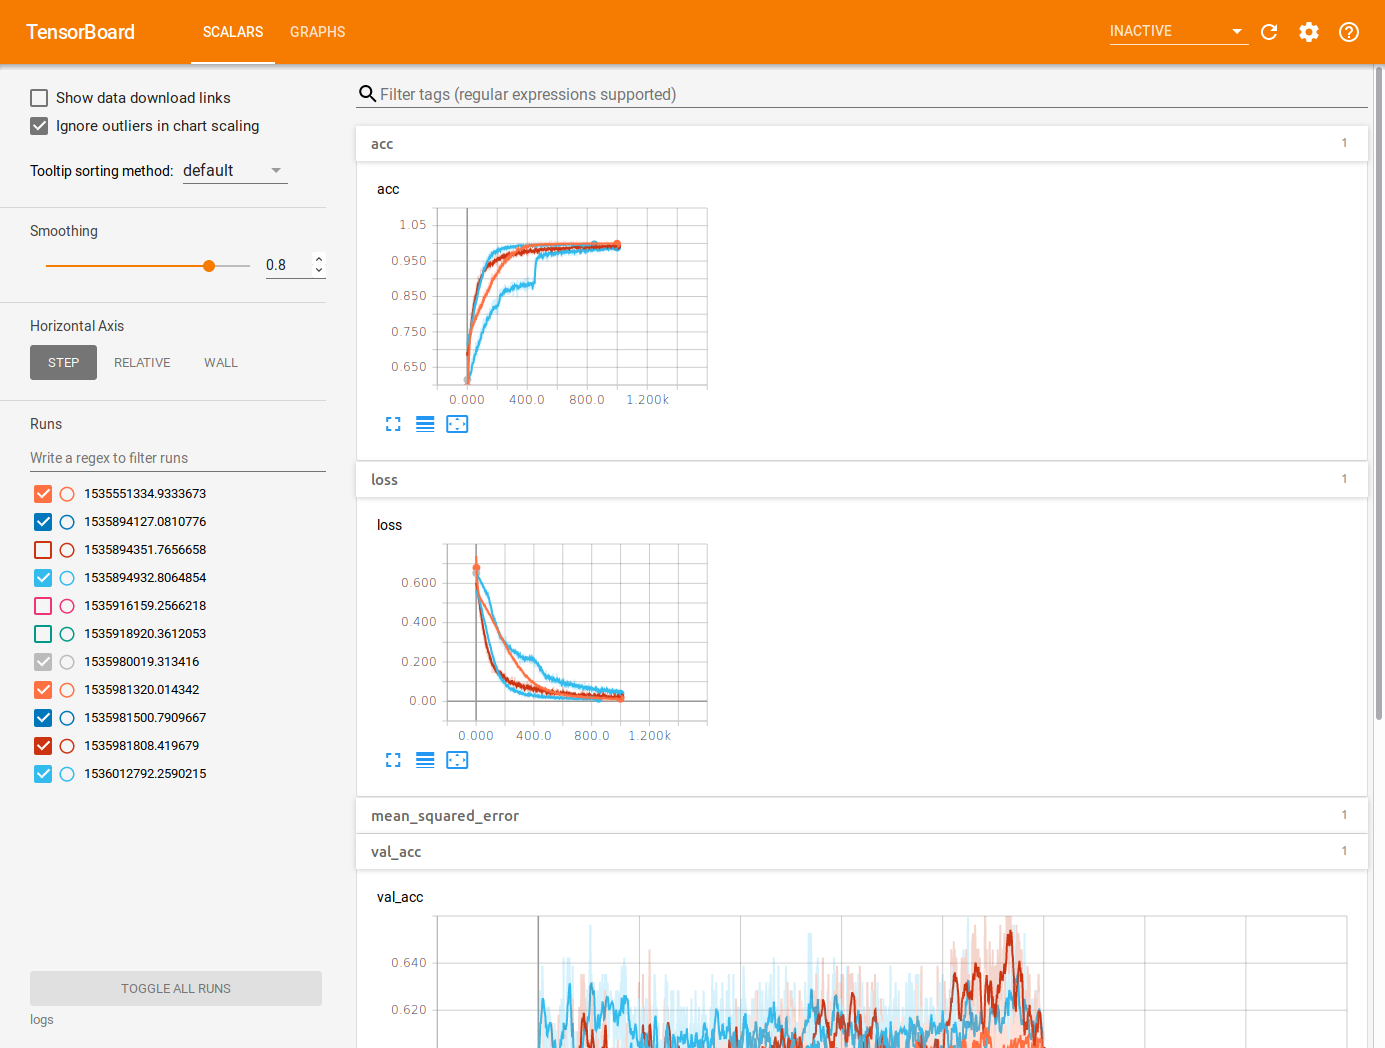

### Accuracy of model on validation data set (20% photo dataset used for validation)

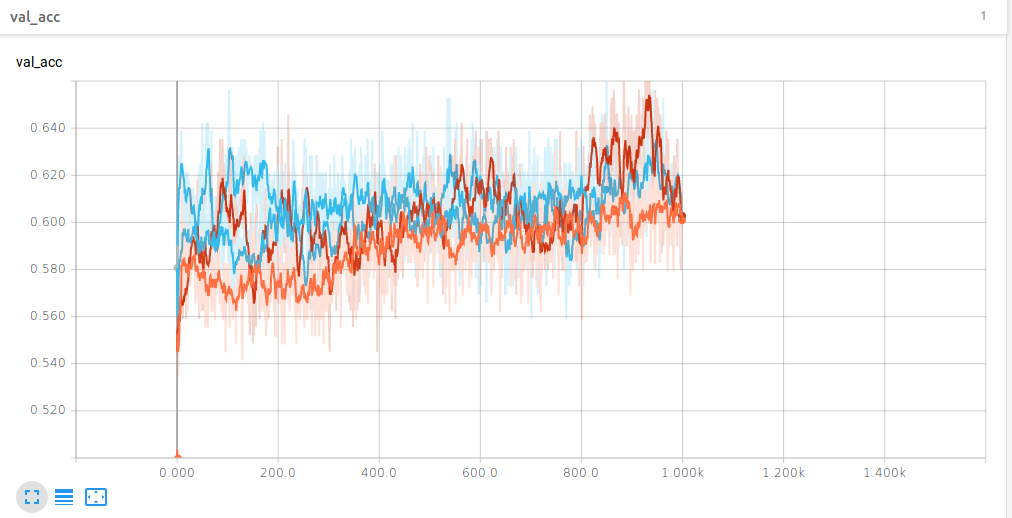

In [20]:
model.save('photoSort.h5')